In [1]:
import pandas as pd
import quandl

In [2]:
df = quandl.get("WIKI/GOOGL")

print(df.head())

              Open    High     Low    Close      Volume  Ex-Dividend  \
Date                                                                   
2004-08-19  100.01  104.06   95.96  100.335  44659000.0          0.0   
2004-08-20  101.01  109.08  100.50  108.310  22834300.0          0.0   
2004-08-23  110.76  113.48  109.05  109.400  18256100.0          0.0   
2004-08-24  111.24  111.60  103.57  104.870  15247300.0          0.0   
2004-08-25  104.76  108.00  103.88  106.000   9188600.0          0.0   

            Split Ratio  Adj. Open  Adj. High   Adj. Low  Adj. Close  \
Date                                                                   
2004-08-19          1.0  50.159839  52.191109  48.128568   50.322842   
2004-08-20          1.0  50.661387  54.708881  50.405597   54.322689   
2004-08-23          1.0  55.551482  56.915693  54.693835   54.869377   
2004-08-24          1.0  55.792225  55.972783  51.945350   52.597363   
2004-08-25          1.0  52.542193  54.167209  52.100830   53.1

too many columns, no point in having both regular and adjusted columns. .. we can remove regular columns and keep only adjusted columns

In [3]:
df = df[['Adj. Open',  'Adj. High',   'Adj. Low',  'Adj. Close', 'Adj. Volume']]

Add High low percentage change .. may generate some insight

In [5]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Low'] * 100.0

Close open percentage change

In [6]:
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

In [59]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
print(df.head())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume
Date                                                     
2004-08-19   50.322842  8.441017    0.324968   44659000.0
2004-08-20   54.322689  8.537313    7.227007   22834300.0
2004-08-23   54.869377  4.062357   -1.227880   18256100.0
2004-08-24   52.597363  7.753210   -5.726357   15247300.0
2004-08-25   53.164113  3.966115    1.183658    9188600.0


In [13]:
import numpy as np
import math

In [9]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

Using numpy module to convert data to numpy array (scikit-learn uses it)
preprocessing to clean and scale the data.. and train_text split is for testing stages

In [60]:
forecast_col = 'Adj. Close'

Fill Not a number (NaN) data with -99999-- using this as a outlier feature. 

In [61]:
df.fillna(value=-99999, inplace=True)

Lets assume we want to foreast 1% of the entire dataset length

In [62]:
forecast_out = int(math.ceil(0.01 * len(df)))

add a new label .. shift our forecast column by desired number of periods.. Basically this is giving our actual prediction after 1% days /dataset period

In [63]:
df['label'] = df[forecast_col].shift(-forecast_out)

In [64]:
print(df.head())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume      label
Date                                                                
2004-08-19   50.322842  8.441017    0.324968   44659000.0  69.639972
2004-08-20   54.322689  8.537313    7.227007   22834300.0  69.078238
2004-08-23   54.869377  4.062357   -1.227880   18256100.0  67.839414
2004-08-24   52.597363  7.753210   -5.726357   15247300.0  68.912727
2004-08-25   53.164113  3.966115    1.183658    9188600.0  70.668146


It is a good idea to drop anykind of NaN still there in the dataframe

In [65]:
df.dropna(inplace=True)

In [93]:
X = np.array(df.drop(['label'], 1))
y = np.array(df['label'])

We should scale our feature in a range from -1 to 1. This will speed up the process and help with accuracy 

In [71]:
X=preprocessing.scale(X)


In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lets use SVM right now for classification

In [73]:
clf = svm.SVR()

In [74]:
clf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [75]:
confidence = clf.score(X_test, y_test)

In [76]:
print(confidence)

0.7874911789899935


accuracy of 78.7%
Lets try another classifier 



In [77]:
clf = LinearRegression()

In [78]:
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [79]:
confidence = clf.score(X_test, y_test)

In [80]:
print(confidence)

0.9757146548770762


Little better classifier .

Now lets try with multiple treads. put n_jobs=-1 for using all the available threads. It will not make any differnce for such a small data, but it will make a huge difference if the data size is more than 20MB

In [81]:
clf = LinearRegression(n_jobs=-1)

In [82]:
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [83]:
confidence = clf.score(X_test, y_test)

In [84]:
print(confidence)

0.9757146548770762


If you want to try multiple kernel.kernel is like a transformation against the data. 

In [85]:
for k in ['linear','poly','rbf','sigmoid']:
    clf = svm.SVR(kernel=k)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print(k,confidence)

linear 0.9741034974295733
poly 0.6995347547432201
rbf 0.7874911789899935
sigmoid 0.8841608862870828


In [94]:
X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]


In [95]:
df.dropna(inplace=True)
y = np.array(df['label'])
y = y[:-forecast_out]

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [97]:
clf = LinearRegression(n_jobs=-1)

In [98]:
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [99]:
confidence = clf.score(X_test, y_test)

In [100]:
print(confidence)

0.9736618913959262


In [101]:
forecast_set = clf.predict(X_lately)

In [102]:
print(forecast_set, confidence, forecast_out)

[1008.44964656 1048.23589205 1050.23203437 1050.6316576  1060.14523056
 1060.51365991 1067.88190172 1060.9237701  1070.58527321 1065.32654767
 1062.81413008 1059.4950288  1059.58768279 1054.71493837 1066.34595179
 1053.40181369 1053.22989156 1068.42403981 1070.47254919 1075.0783405
 1089.5148855  1080.2045872  1053.44526098 1053.65785953 1041.99955666
 1028.5523286  1035.10700634 1049.40562261 1062.34426724 1067.49640641
 1070.0882707  1066.19998515 1069.69226246 1075.37097138] 0.9736618913959262 34


In [103]:
import datetime
import matplotlib.pyplot as plt
from matplotlib import style

import datetime object, matplotlib pyplot package for graphing and style create better looking graphs

In [104]:
style.use('ggplot')

In [105]:
df['Forecast'] = np.nan

In [106]:
last_date = df.iloc[-1].name

In [107]:
last_unix = last_date.timestamp()

In [108]:
one_day = 86400
next_unix = last_unix + one_day

In [109]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

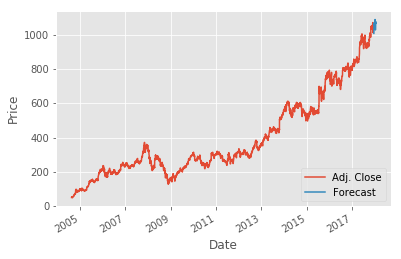

In [110]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### storing classifier with pickle

In [111]:
import pickle

In [112]:
with open('linearregression.pickle','wb') as f:
    pickle.dump(clf, f)

In [113]:
pickle_in = open('linearregression.pickle','rb')
clf = pickle.load(pickle_in)

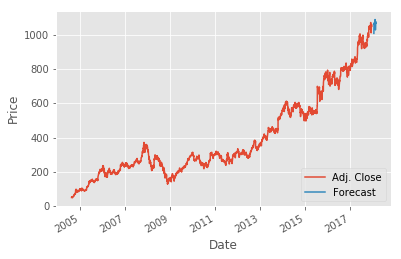

In [114]:
forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()